# Multilingual BERT Approach on English

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

import sklearn
from sklearn.model_selection import train_test_split

import transformers

from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import backend as K

import logging
tf.get_logger().setLevel(logging.ERROR)

In [3]:
#Check for GPU presence
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Read in the Data

In [4]:
english = pd.read_csv("data/olid/olid-training-v1.0.tsv", sep ="\t")
english

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [5]:
#Resettting df to be amharic_data to be easier to use remaining code
amharic_data = english

In [6]:
#Creating new column with 0/1
amharic_data["label"] = np.nan
amharic_data.loc[(amharic_data["subtask_a"] == "OFF"), "label"] = 1
amharic_data.loc[(amharic_data["subtask_a"] == "NOT"), "label"] = 0
amharic_data

,id,tweet,subtask_a,subtask_b,subtask_c,label
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,1.0
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,1.0
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,0.0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,1.0
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,0.0
...,...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,1.0
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,0.0
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,1.0
13238,27429,@USER Pussy,OFF,UNT,NaN,1.0


In [7]:
#load our tuned Amharic dataset
amharic_train, amharic_test = train_test_split(amharic_data, train_size=0.8)
amharic_test, amharic_dev = train_test_split(amharic_test, train_size=0.5)
print(amharic_train.shape)
print(amharic_test.shape)
print(amharic_dev.shape)

(10592, 6)
(1324, 6)
(1324, 6)


In [8]:
amharic_train

,id,tweet,subtask_a,subtask_b,subtask_c,label
12662,54676,Lyin #BrettKavanaugh &amp; His Sexual Assault ...,NOT,NaN,NaN,0.0
1456,54306,@USER @USER Hillary? Why is she on the social ...,OFF,TIN,IND,1.0
10432,85283,@USER Antifa is a domestic terror organisation...,NOT,NaN,NaN,0.0
5645,44586,@USER @USER @USER There are people and groups ...,NOT,NaN,NaN,0.0
2240,35695,@USER It only hangs in the balance because of ...,NOT,NaN,NaN,0.0
...,...,...,...,...,...,...
4025,94903,@USER @USER What about the game clincher. He b...,NOT,NaN,NaN,0.0
9718,60107,@USER Fake News,OFF,UNT,NaN,1.0
10884,31247,@USER @USER @USER @USER @USER @USER @USER And ...,NOT,NaN,NaN,0.0
6549,53573,@USER @USER Now I see why the Conservatives lo...,NOT,NaN,NaN,0.0


## Preparing to run BERT

In [9]:
#NEED to import and load both of these
#using the pretrained model called bert-base-cased
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<AxesSubplot:>

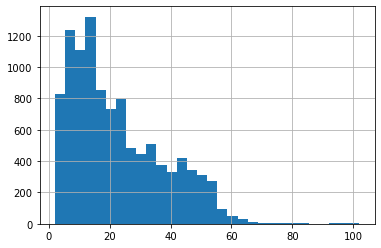

In [10]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in amharic_train.tweet]

pd.Series(seq_len).hist(bins = 30)


#It looks like the max length peters out after 50 although it goes up to 250 length

In [ ]:
bert_model.summary()

In [11]:

max_length = 50 #use from chart above

num_examples = 1000
#num_examples = len(amharic_train.tweet)

x_train = tokenizer([x for x in amharic_train.tweet][:num_examples], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = tf.convert_to_tensor(amharic_train.label[:num_examples])




x_dev = tokenizer([x for x in amharic_dev.tweet][:num_examples], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_dev = tf.convert_to_tensor(amharic_dev.label[:num_examples])

In [23]:
#Let's look at class imbalance
print('ratio of positive examples: ', np.sum(y_train==1)/len(y_train))
#y_train

ratio of positive examples:  0.504962962962963


In [24]:
x_train

{'input_ids': <tf.Tensor: shape=(27000, 50), dtype=int32, numpy=
array([[101, 100, 100, ...,   0,   0,   0],
       [101, 100, 100, ...,   0,   0,   0],
       [101, 100, 100, ...,   0,   0,   0],
       ...,
       [101, 100, 100, ...,   0,   0,   0],
       [101, 100, 100, ...,   0,   0,   0],
       [101, 100, 100, ...,   0,   0,   0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(27000, 50), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(27000, 50), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

## Building the Classification Model

In [12]:
#From BERT_Fine_tuning Walkthrough Notebook/Session

def create_classification_model(hidden_size = 200, 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam()):
    """
    Build a simple classification model with BERT. Let's keep it simple and don't add dropout, layer norms, etc.
    """

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}


    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = bert_model(bert_inputs) #same as x_tiny example above, always set ouput to model acting on input

    
    #getting the CLS token, could change to bert_out[1]
    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0]) 


    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer',activation='relu')(classification_token)
    
    hidden2 = tf.keras.layers.Dense(hidden_size, name='hidden_layer2',activation='relu')(hidden)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden2)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics='accuracy')


    return classification_model

## Experimentation
Creating models and changing parameters

#### Model 1: Following Model 1 from BERT_Fine_tuning walkthrough notebook

In [13]:
classification_model = create_classification_model(optimizer=tf.keras.optimizers.Adam(0.00005))  

In [14]:
#This took a long time, may want to increase batch_size for next run?
classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_dev.input_ids, x_dev.token_type_ids, x_dev.attention_mask],
                         y_dev),
                        epochs=5,
                        batch_size=10)

Epoch 1/5
100/100 [==============================] - 28s 197ms/step - loss: 0.6163 - accuracy: 0.7018 - val_loss: 0.6307 - val_accuracy: 0.6610
Epoch 2/5
100/100 [==============================] - 18s 176ms/step - loss: 0.5835 - accuracy: 0.7128 - val_loss: 0.6108 - val_accuracy: 0.7100
Epoch 3/5
100/100 [==============================] - 18s 178ms/step - loss: 0.5589 - accuracy: 0.7598 - val_loss: 0.6274 - val_accuracy: 0.6830
Epoch 4/5
100/100 [==============================] - 18s 179ms/step - loss: 0.6021 - accuracy: 0.7364 - val_loss: 0.6475 - val_accuracy: 0.6610
Epoch 5/5
100/100 [==============================] - 18s 181ms/step - loss: 0.6177 - accuracy: 0.6960 - val_loss: 0.6370 - val_accuracy: 0.6770


In [15]:
predictions = classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask], ) #output represents likelihood example was in the positive class
#these are all about the same and not very confident either way about whether example is in the class or not
predictions

array([[0.27059484],
       [0.2696303 ],
       [0.2696888 ],
       [0.2692753 ],
       [0.26968333],
       [0.9643061 ],
       [0.26969713],
       [0.2697132 ],
       [0.2701217 ],
       [0.26889256],
       [0.27006915],
       [0.26882908],
       [0.26903936],
       [0.26970384],
       [0.26948008],
       [0.26942965],
       [0.2696312 ],
       [0.2696685 ],
       [0.26856795],
       [0.26994434],
       [0.26959875],
       [0.26949593],
       [0.26957875],
       [0.2696573 ],
       [0.26912746],
       [0.27006558],
       [0.26856795],
       [0.26938304],
       [0.2698845 ],
       [0.26958004],
       [0.26924857],
       [0.2691555 ],
       [0.26970997],
       [0.2691587 ],
       [0.269322  ],
       [0.26856795],
       [0.2702536 ],
       [0.26932856],
       [0.26963404],
       [0.26961792],
       [0.2692421 ],
       [0.26887497],
       [0.27001   ],
       [0.2695263 ],
       [0.26950788],
       [0.2698029 ],
       [0.26962775],
       [0.269

In [16]:
np.unique(predictions) #At least the English model is learning ... Could look at cases where English is failing?

array([0.26856795, 0.26857463, 0.26859784, 0.26860276, 0.2686183 ,
       0.2686579 , 0.26866874, 0.2686863 , 0.26868922, 0.2686942 ,
       0.26871616, 0.26875082, 0.26875648, 0.2687788 , 0.2687808 ,
       0.2687848 , 0.26878592, 0.26882863, 0.26882908, 0.26883084,
       0.26883557, 0.26883915, 0.26884386, 0.26884404, 0.2688454 ,
       0.26887468, 0.26887497, 0.26888594, 0.26888964, 0.26889256,
       0.268894  , 0.26891637, 0.26892203, 0.2689269 , 0.26892897,
       0.26894432, 0.26894847, 0.26895064, 0.2689624 , 0.2689653 ,
       0.26896748, 0.26897228, 0.26897374, 0.26897496, 0.26898077,
       0.26899704, 0.26899773, 0.268998  , 0.2690027 , 0.2690129 ,
       0.26901948, 0.26901978, 0.26902542, 0.26902547, 0.26902717,
       0.269032  , 0.26903936, 0.26904637, 0.26904702, 0.2690501 ,
       0.26905024, 0.2690505 , 0.26906276, 0.26906562, 0.26908028,
       0.26908585, 0.26908997, 0.26909152, 0.26909408, 0.26909438,
       0.26909646, 0.26909688, 0.26909855, 0.26909918, 0.26909

In [30]:
# Generate generalization metrics
score = classification_model.evaluate([x_dev.input_ids, x_dev.token_type_ids, x_dev.attention_mask],
                         y_dev, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.6930848956108093 / Test accuracy: 0.5206666588783264


In [22]:
#Creating some new columns & printing out a csv with the predicted labels
amharic_train["predicted_label"] = np.nan
amharic_train["predicted_stat"] = predictions
amharic_train.loc[(amharic_train["predicted_stat"] >= 0.5), "predicted_label"] = 1
amharic_train.loc[(amharic_train["predicted_stat"] < 0.5), "predicted_label"] = 0
amharic_train.to_csv("Amharic_train_predictions")

<ipython-input-22-7565c2f4f57a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amharic_train["predicted_label"] = np.nan
<ipython-input-22-7565c2f4f57a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amharic_train["predicted_stat"] = predictions
/home/joanieweaver/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

#### Model 2: Following Model 2 from BERT Walkthrough notebook
Updating learning rate

In [ ]:
#do same thing as above but change learning rate in Adam below, need to get fresh bert model
try:
    del classification_model
except:
    pass

try:
    del bert_model
except:
    pass

tf.keras.backend.clear_session()

#NEED to import and load both of these
#using the pretrained model called bert-base-cased
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

classification_model = create_classification_model(optimizer=tf.keras.optimizers.Adam(0.00005))

classification_model.fit([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
                         y_train,
                         validation_data=([x_dev.input_ids, x_dev.token_type_ids, x_dev.attention_mask],
                         y_dev),
                        epochs=5,
                        batch_size=10)

classification_model.predict([x_train.input_ids, x_train.token_type_ids, x_train.attention_mask])


#This looks a little worse, not sure why it's now predicting 54% consistently

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
2700/2700 [==============================] - 413s 150ms/step - loss: 0.6996 - accuracy: 0.4995 - val_loss: 0.6937 - val_accuracy: 0.5040
Epoch 2/5
2700/2700 [==============================] - 404s 150ms/step - loss: 0.6945 - accuracy: 0.4970 - val_loss: 0.6933 - val_accuracy: 0.5040
Epoch 3/5
2700/2700 [==============================] - 404s 150ms/step - loss: 0.6941 - accuracy: 0.4976 - val_loss: 0.6933 - val_accuracy: 0.5040
Epoch 4/5
1981/2700 [=====================>........] - ETA: 1:46 - loss: 0.6938 - accuracy: 0.5006

In [22]:
# Generate generalization metrics
score = classification_model.evaluate([x_dev.input_ids, x_dev.token_type_ids, x_dev.attention_mask],
                         y_dev, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.6977327466011047 / Test accuracy: 0.4959999918937683


In [21]:
classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask_layer (InputLaye [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_ids_layer (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
token_type_ids_layer (InputLaye [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   attention_mask_layer[0][0]       
                                                                 input_ids_layer[0][0]        

In [24]:
classification_model.save_model("models/BERT_multilingual_adam_v1")
tokenizer.save_pretrained("tokenizers/BERT_multilingual_v1")

AttributeError: 'Functional' object has no attribute 'save_model'